In [3]:
import torch
from torch import nn

In [2]:
torch.cuda.is_available()

True

In [14]:
def corr2d(X, K):
    # 位相关运算
    h, w = X.shape[-2], X.shape[-1]
    kh, kw = K.shape[0], K.shape[1]
    Y = torch.zeros(h-kh+1, w-kw+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+kh, j:j+kh]*K).sum()
    
    return Y

class Conv2D(nn.Module):
    def __init__(self, kernel_size) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [15]:
# 下面y相当于是边缘检查核，是早期的图像特征提取的方法
# 但是注意卷积神经网络的核都是训练出来的
x = torch.cat([torch.ones((6, 3)), torch.zeros((6, 3))], axis = 1)
k = torch.tensor([[-1,1], [-1,1]])

y = corr2d(x, k)
x, y

(tensor([[1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.]]),
 tensor([[ 0.,  0., -2.,  0.,  0.],
         [ 0.,  0., -2.,  0.,  0.],
         [ 0.,  0., -2.,  0.,  0.],
         [ 0.,  0., -2.,  0.,  0.],
         [ 0.,  0., -2.,  0.,  0.]]))

In [37]:
# train 得到上面的k
net = Conv2D((2,2))
lr = 0.02

for i in range(10):
    y_hat = net(x)
    l = (y-y_hat)**2
    net.zero_grad()
    l.sum().backward()
    net.weight.data[:] -= lr*net.weight.grad

    print('epoch:{}, loss:{}'.format(i, l.sum()))

epoch:0, loss:116.1138916015625
epoch:1, loss:78.9574203491211
epoch:2, loss:53.69102478027344
epoch:3, loss:36.509891510009766
epoch:4, loss:24.82672119140625
epoch:5, loss:16.882171630859375
epoch:6, loss:11.479884147644043
epoch:7, loss:7.806321144104004
epoch:8, loss:5.308300495147705
epoch:9, loss:3.6096436977386475


In [38]:
net.weight

Parameter containing:
tensor([[-0.6748,  0.6303],
        [-0.7964,  1.1660]], requires_grad=True)

In [5]:
# 填充与步幅
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 3), stride=2, padding=1)
x = torch.randn((1 ,1, 5, 5))

conv2d(x).shape

torch.Size([1, 1, 3, 3])

In [12]:
# 汇聚层
maxpool = nn.MaxPool2d((2,2), stride=1, padding=0)
avgpool = nn.AvgPool2d((2,2), stride=1, padding=0)
maxpool(x), avgpool(x)

(tensor([[[[ 0.3358,  0.3331,  0.3331,  0.3109],
           [ 0.3358,  0.3331,  0.3331,  2.0902],
           [ 1.1293,  1.1293,  0.7845,  2.0902],
           [ 1.1293,  1.1293,  0.7845, -0.5532]]]]),
 tensor([[[[-0.2446, -0.2797, -0.5868, -0.8199],
           [-0.1363, -0.3465, -0.6522,  0.0318],
           [ 0.5937,  0.3223, -0.1649, -0.0622],
           [ 0.6217,  0.1743, -0.5181, -1.0981]]]]))

In [14]:
relu = nn.ReLU()
relu(avgpool(x))

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0318],
          [0.5937, 0.3223, 0.0000, 0.0000],
          [0.6217, 0.1743, 0.0000, 0.0000]]]])

In [11]:
import torchvision
from torchvision import transforms

# 定义net来train FashionMNIST
mnist_train = torchvision.datasets.FashionMNIST(
    root='../data', train=True, transform=transforms.ToTensor(), download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root='../data', train=False, transform=transforms.ToTensor(), download=True
)

In [29]:
mnist_train.data.shape, mnist_train.targets.shape
max(mnist_train.targets)

tensor(9)

In [138]:
class CnnNet(nn.Module):
    def __init__(self, input_channels=1) -> None:
        super().__init__()
        self.is_training = True
        self.drop_layer = nn.Dropout(0.5)
        self.conn2d1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conn2d2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(5,5), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conn2d3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(5,5), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conn2d4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(2,2), stride=1, padding=1),
            # nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # self.conv1 = nn.Conv2d(1, 6, kernel_size=(3,3), stride=1, padding=1)
        # self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        # self.conv2 = nn.Conv2d(6, 16, kernel_size=(3,3), stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        # self.line1 = nn.Sequential(
        #     nn.Linear(784, 120),
        #     nn.ReLU(),
        #     nn.Linear(120, 84),
        #     nn.ReLU(),
        #     nn.Linear(84, 10)
        # )
        self.line1 = nn.Linear(1152, 256)
        self.line2 = nn.Linear(256, 10)
        # self.line1 = nn.Linear(1152, 240)
        # self.line2 = nn.Linear(240, 84)
        # self.line3 = nn.Linear(84, 10)

    
    def forward(self, x):
        # c1 = self.conv1(x)
        # c1 = self.relu(self.maxpool(c1))
        # c2 = self.conv2(c1)
        # c2 = self.relu(self.maxpool(c2))
        c1 = self.conn2d1(x)
        c2 = self.conn2d2(c1)
        c3 = self.conn2d3(c2)
        c4 = self.conn2d4(c3)
        o1 = self.flatten(c4)
        # return o1
        # l = self.line(o1)
        l1 = self.relu(self.line1(o1))
        if self.is_training:
            l1 = self.drop_layer(l1)
        
        # l2 = self.relu(self.line2(l1))
        # if self.is_training:
        #     l2 = self.drop_layer(l2)
        # l3 = self.line3(l2)
        o = self.line2(l1)
        return o

    def predict(self, x):
        self.is_training = False
        o = self.forward(x)
        self.is_training = True
        return o

In [15]:
# alexNet
class CnnNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.is_training = True
        self.drop_layer = nn.Dropout(0.5)
        self.conn2d1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU()
        )
        self.conn2d2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=(5,5), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conn2d3 = nn.Sequential(
            nn.Conv2d(256, 1024, kernel_size=(5,5), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.conn2d4 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=(2,2), stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.line1 = nn.Linear(9216, 4080)
        self.line2 = nn.Linear(4080, 10)


    
    def forward(self, x):
        c1 = self.conn2d1(x)
        c2 = self.conn2d2(c1)
        c3 = self.conn2d3(c2)
        c4 = self.conn2d4(c3)
        o1 = self.flatten(c4)
        # return o1
        l1 = self.relu(self.line1(o1))
        if self.is_training:
            l1 = self.drop_layer(l1)
        o = self.line2(l1)
        return o

    def predict(self, x):
        self.is_training = False
        o = self.forward(x)
        self.is_training = True
        return o

In [16]:
from torchinfo import summary

net = CnnNet()
summary(net, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
CnnNet                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 96, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 96, 28, 28]           960
│    └─MaxPool2d: 2-2                    [1, 96, 14, 14]           --
│    └─BatchNorm2d: 2-3                  [1, 96, 14, 14]           192
│    └─ReLU: 2-4                         [1, 96, 14, 14]           --
├─Sequential: 1-2                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-5                       [1, 256, 12, 12]          614,656
│    └─MaxPool2d: 2-6                    [1, 256, 6, 6]            --
│    └─BatchNorm2d: 2-7                  [1, 256, 6, 6]            512
│    └─ReLU: 2-8                         [1, 256, 6, 6]            --
├─Sequential: 1-3                        [1, 1024, 2, 2]           --
│    └─Conv2d: 2-9                       [1, 1024, 4, 4]           6,554,624


In [17]:
from torch.utils import data

def ac(data_iter, net, device):
    num_acs = []
    for x, y in data_iter:
        x = x.to(device)
        y = y.to(device)
        y_hat = net.predict(x)
        maxs, indexs = torch.max(y_hat, dim=1)
        num_acs.append(y.eq(indexs).sum()/indexs.shape[0])
    return sum(num_acs)/len(num_acs)

batch_size = 1024
num_epochs = 10
lr = 0.1

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_iter = data.DataLoader(mnist_test, batch_size,shuffle=True, num_workers=4)

net = CnnNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [18]:
for i in range(num_epochs):
    for x,y in train_iter:
        x = x.to(device)
        y = y.to(device)
        y_hat = net(x)
        l = loss(y_hat, y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    print(l)
    print(ac(test_iter, net, device))

tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8501, device='cuda:0')
tensor(0.3665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8668, device='cuda:0')
tensor(0.2419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8850, device='cuda:0')
tensor(0.1940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8838, device='cuda:0')
tensor(0.1536, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9118, device='cuda:0')
tensor(0.1558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9051, device='cuda:0')
tensor(0.1687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8950, device='cuda:0')
tensor(0.1154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9192, device='cuda:0')
tensor(0.1137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9167, device='cuda:0')
tensor(0.0946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9094, device='cuda:0')


In [142]:
o = torch.tensor(mnist_test.data[1,:,:].reshape(1,1,28,28).cuda(), dtype=torch.float32)
torch.softmax(net(o), dim=1), mnist_test.targets[1]

C:\Users\cheng\AppData\Local\Temp\ipykernel_10468\3493962570.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  o = torch.tensor(mnist_test.data[1,:,:].reshape(1,1,28,28).cuda(), dtype=torch.float32)


(tensor([[2.7844e-06, 1.1906e-07, 9.9640e-01, 5.5539e-06, 2.1888e-03, 7.1823e-06,
          1.3271e-03, 7.3079e-06, 5.9558e-05, 1.0692e-06]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(2))

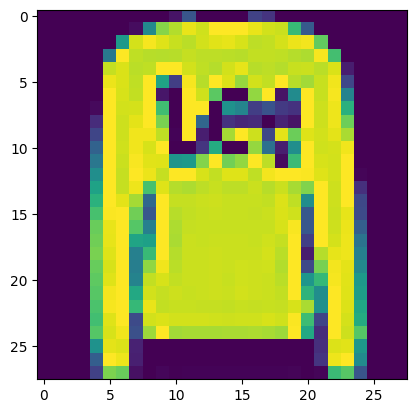

In [149]:
import matplotlib.pyplot as plt

plt.imshow(o.reshape(28,28).cpu().numpy())